# AlexNet - CIFAR10 - keras


## Imports

In [1]:
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
!pip freeze | grep -e "tensorflow==" -e "keras=="

keras==2.10.0


In [4]:
import tensorflow as tf

from tensorflow.keras import layers, Model, Input, callbacks
from tensorflow.keras.regularizers import L2

2023-01-31 14:44:52.040610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 14:44:52.117630: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-31 14:44:52.471889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-31 14:44:52.471923: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [5]:
from tqdm.keras import TqdmCallback

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU: {device_name}')

Found GPU: /device:GPU:0


2023-01-31 14:44:53.167940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 14:44:53.196531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 14:44:53.210740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 14:44:53.210915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import numpy as np

## Load and prepare data

In [10]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [11]:
no_classes = 10
classe_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [12]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [13]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.,  x_test / 255.
y_train, y_test = y_train.flatten(), y_test.flatten()

In [14]:
# Fixing seed for Python, NumPy, and TensorFlow
seed = 0
tf.keras.utils.set_random_seed(seed)

In [15]:
# Split train val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=0)

In [16]:
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

print("\nx_test.shape:", x_test.shape)
print("y_test.shape", y_test.shape)

print("\nx_val.shape:", x_val.shape)
print("y_val.shape", y_val.shape)

x_train.shape: (40000, 32, 32, 3)
y_train.shape (40000,)

x_test.shape: (10000, 32, 32, 3)
y_test.shape (10000,)

x_val.shape: (10000, 32, 32, 3)
y_val.shape (10000,)


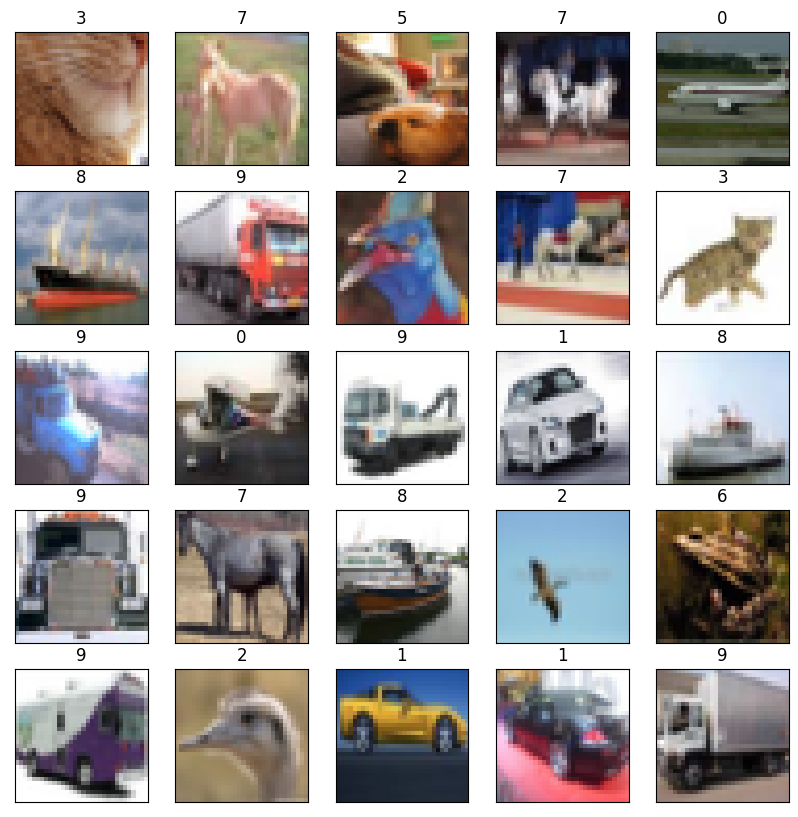

In [17]:
# Plot grid with first 25 training images with their corresponding label
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(y_train[i])
plt.show()

## Defining a training class

## Building architecture then model

In [18]:
batch_size = 512
epochs = 100
dropout_rate = .25
# regularization_coef = .001

In [19]:
def get_alexnet(input_shape=(32, 32, 3)):
    X_input = layers.Input(input_shape)
    X = layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.MaxPooling2D((3, 3))(X)

    X = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.MaxPooling2D((2, 2))(X)
    
    X = layers.Conv2D(filters=384, kernel_size=(5, 5), strides=(1, 1), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(filters=384, kernel_size=(5, 5), strides=(1, 1), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((2, 2))(X)
    
    ### Prediction bloc
    X = layers.Flatten()(X)
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(no_classes)(X)
    X_output = layers.Activation('softmax')(X)
    return Model(inputs=[X_input], outputs=[X_output], name='alexnet')

In [20]:
img_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
img_shape

(32, 32, 3)

In [21]:
# Define model, for a fully-connected network the input must be properly adapted
model = get_alexnet(img_shape)

# Set hyperparameters
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(3e-4)
metric = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_acc')
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25),
    TqdmCallback(verbose=0)
]

# Initialize trainer
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Train model
start_time = time.time()
results = model.fit(
    x_train, y_train,
    batch_size, epochs, 
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=0 # Supress fitting information
)

predictions = model.predict(x_test)
metric(y_test, predictions)
print(f'Execution time: {round(time.time() - start_time, 2)}s - Test accuracy: {metric.result()*10.:.2f}%')

2023-01-31 14:44:54.859263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 14:44:54.859448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 14:44:54.859576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 14:44:54.859818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 14:44:54.859951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

0epoch [00:00, ?epoch/s]

2023-01-31 14:44:56.307581: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-01-31 14:44:56.894324: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-31 14:44:56.894352: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


313/313 [==============================] - 1s 3ms/step
Execution time: 378.83s - Test accuracy: 16.27%


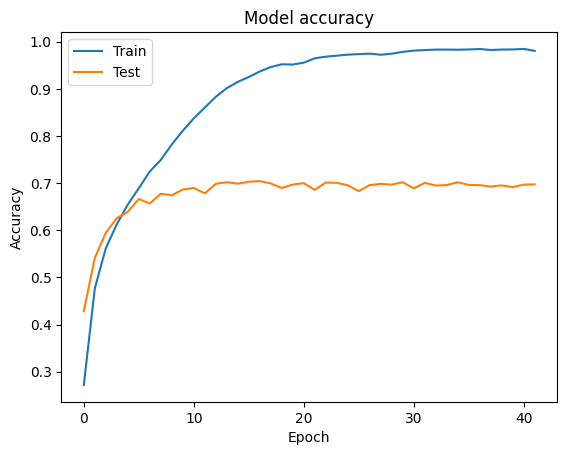

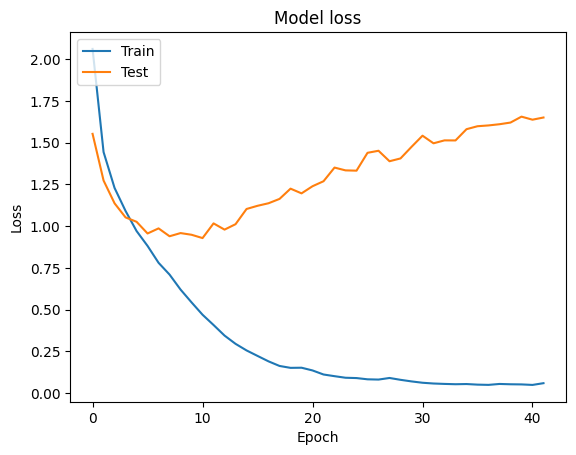

In [22]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
flat_preds= np.argmax(predictions, axis=1)
flat_preds.shape

(10000,)

In [24]:
confusion = confusion_matrix(y_test, flat_preds)
confusion

array([[718,  21,  57,  22,  18,   7,  21,   7,  87,  42],
       [ 22, 800,   2,  17,   4,   7,  14,   4,  35,  95],
       [ 61,   4, 545,  69,  86,  91,  87,  35,  17,   5],
       [ 18,  10,  67, 520,  58, 202,  68,  22,  15,  20],
       [ 25,   2,  76,  85, 616,  57,  69,  53,  14,   3],
       [ 14,   3,  46, 155,  44, 642,  33,  43,  14,   6],
       [  4,   9,  41,  70,  31,  35, 793,   3,   9,   5],
       [ 20,   2,  37,  51,  65,  85,  15, 708,   3,  14],
       [ 51,  34,  14,  18,  10,  12,   7,   3, 820,  31],
       [ 30, 100,  14,  17,   3,  17,  11,  21,  37, 750]])

Accuracy on unseen data: 16.27%


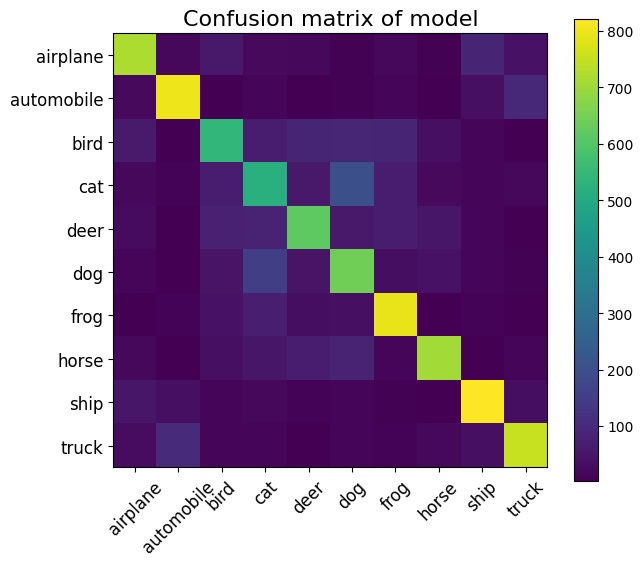

In [30]:
print(f'Accuracy on unseen data: {metric.result()*10.:.2f}%')

plt.figure(figsize=(7, 6))
plt.title(f'Confusion matrix of model', fontsize=16)
plt.imshow(confusion)
plt.xticks(np.arange(10), classe_names, rotation=45, fontsize=12)
plt.yticks(np.arange(10), classe_names, fontsize=12)
plt.colorbar()
plt.show()